<a href="https://colab.research.google.com/github/Jason-Morrill/mlns-proyecto-imagenes/blob/glopez/Microproyecto1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado

### Integrantes
- _Gloria López_
- _Jason Morrill_

### Objetivo
Desarrollar un método, basado en **técnicas de agrupación**, que permita extraer los tonos de una imagen y generar un muestrario de los colores presentes en esta.

### Conjunto de datos
Extraído del dataset  [Kaggle **wikiart**](https://www.kaggle.com/datasets/steubk/wikiart)


## 1. Importación de librerías requeridas

In [ ]:
!pip install scikit-learn-extra
!pip install pyclustering
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395099 sha256=515e1e1960df853a8fc9c6ff430f57c62ee18b7185f2d5a1738c8dfacb3ff9b0
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [ ]:
# Librerias
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator # para encontrar los clusters optimos
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Variables globales
glb_random_state = 42
cluster_range = []

In [ ]:
# Funciones útiles
def print_seconds(inicio, fin):
    duracion = fin - inicio
    return f"Tiempo de ejecución: {duracion:.2f} segundos"


## 2. Carga de datos

A continuación se muestran las imágenes con las que se trabajará el siguiente laboratorio:

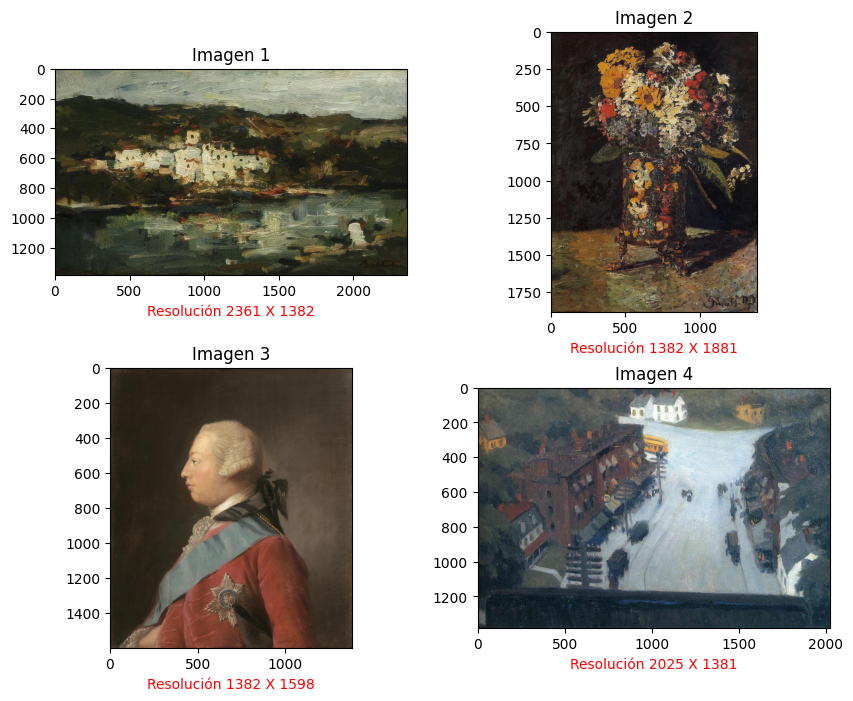

In [ ]:
list_images = []
list_images_routes = []
download_folder = "wikiart_images"
full_image_path = os.path.join(download_folder, "adam-baltatu_olt-river-at-cozia.jpg")
list_images_routes.append(full_image_path)
list_images.append(Image.open(full_image_path))

full_image_path = os.path.join(download_folder, "adolphe-joseph-thomas-monticelli_bouquet-of-flowers.jpg")
list_images_routes.append(full_image_path)
list_images.append(Image.open(full_image_path))

full_image_path = os.path.join(download_folder, "allan-ramsay_portrait-of-king-george-iii.jpg")
list_images_routes.append(full_image_path)
list_images.append(Image.open(full_image_path))

full_image_path = os.path.join(download_folder, "edward-hopper_american-village.jpg")
list_images_routes.append(full_image_path)
list_images.append(Image.open(full_image_path))

# Dibujar las imágenes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(list_images[i])
    width, height = list_images[i].size
    ax.set_title(f"Imagen {i+1}")
    ax.set_xlabel(f"Resolución {width} X {height}")
    ax.xaxis.label.set_color('red')

plt.show()
list_images = None # Liberar memoria

Se observan diferentes resoluciones, son bastantes altas para trabajarlas.

#### Redimensionar las imágenes  
A continuación se definirán las funciones necesarias para transformar la imagen de pixeles a un rango entre 0 y 1, como valores de entrada para los algoritmos de agrupación

1. Disminuir la resolución de la imagen sin perder su calidad y colores

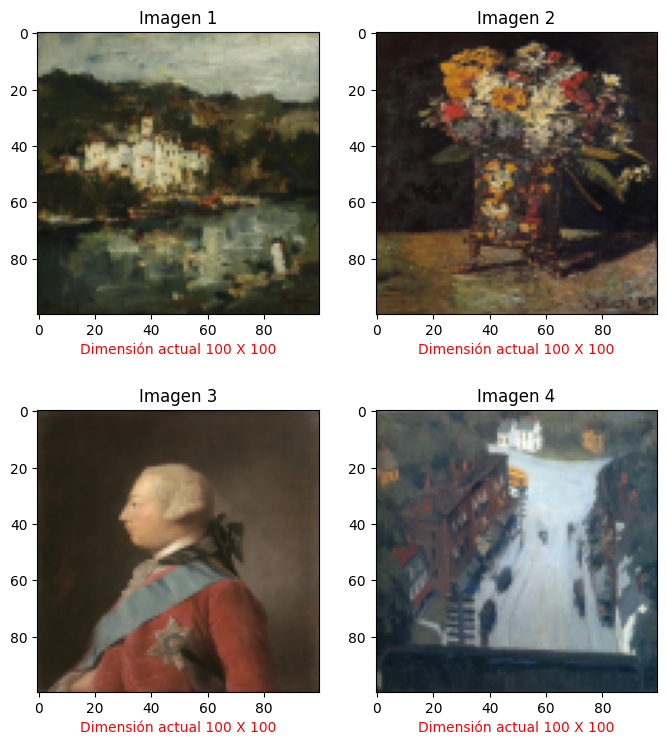

In [ ]:
# Cambiar el tamaño de las imágenes
# Notas: al invocar este método `cv.resize` sin ningún argumento adicional, se ha observado que la imagen pierde bastante su color, por lo que se asigna `interpolation=cv2.INTER_AREA`.
#       Así minimiza la pérdida de color y calidad al reducir la imagen.
def resize_image(image, width, height):
    return cv.resize(image, (width, height), interpolation=cv.INTER_AREA)

# Obtener el color en RGB: otro método para obtener el color de la imagen original
def get_rgb_color(image):
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)


list_images_resized = []
# Definición cambio de tamaño  → ## target_size=(150, 150)# Added target_size
ancho_nuevo = 100 #300
alto_nuevo = 100 #200
def custom_resize_image():
    for image_route in list_images_routes:
        # Read image
        img = cv.imread(image_route)
        # Handle case where image is not read
        if img is None:
            print(f"Failed to read image: {image_route}")
            continue  # Skip to next file

        # Resize image
        img = get_rgb_color(img) # obtener color original
        img = resize_image(img, ancho_nuevo, alto_nuevo)
        list_images_resized.append(img)

    # Dibujar las imágenes
    fig, axes = plt.subplots(2, 2, figsize=(8, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(list_images_resized[i])
        height, width, canales = list_images_resized[i].shape
        ax.set_title(f"Imagen {i+1}")
        ax.set_xlabel(f"Dimensión actual {width} X {height}") #Canales de color: {canales}
        ax.xaxis.label.set_color('red')

    plt.show()


custom_resize_image()

2. Proceso de aplanar y normalizar las imágenes

In [ ]:
# ============= Proceso de aplanar y normalizar las imágenes =======================================

# Segun el taller semana 3: aplanar
def flatten_images(image):
    return image.reshape(-1, 3) #image.reshape((-1, 3))

# Dividir por 255 para que todos los valores estén en el rango 0 - 1 (no es necesario para archivos PNG)
def normalize_image(image):
    return image / 255.0

# Aplanar y normalizar las imágenes
# list_images_resized  # Imágenes redimensionadas
def flatten_normalize_resized_images(flatten=True, normalize=True, useScaler=False):
    image_list = list()
    for image_resized in list_images_resized:
        if flatten:
            image_resized = flatten_images(image_resized)

        # Normalizar la imagen
        if useScaler:
            scaler = StandardScaler()
            image_resized = scaler.fit_transform(image_resized)
        elif normalize:
            image_resized = normalize_image(image_resized)

        image_list.append(image_resized)
    return image_list

In [ ]:
transformed_images = flatten_normalize_resized_images(flatten=True, normalize=True)
transformed_images[0]

array([[0.43529412, 0.44313725, 0.35294118],
       [0.45098039, 0.45882353, 0.36862745],
       [0.4       , 0.41568627, 0.29411765],
       ...,
       [0.14901961, 0.15294118, 0.09803922],
       [0.14509804, 0.14901961, 0.10980392],
       [0.14509804, 0.14901961, 0.11764706]])

## 3. Segmentación de imágenes

#### Algoritmo de agrupación K-means o KMedoids

`silhouette_elbow_function` esta función permite obtener los `inertia_` para el método del codo y `silhouette_score` para el método de la silueta.

In [ ]:
# Función para obtener el coeficiente de la silueta y la inercia por medio de los algoritmos KMeans ó KMedoids
def silhouette_elbow_function(X, model, k_min, k_max):
    scores = []
    inertias = []
    cluster_range = range(k_min, k_max+1)
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=glb_random_state)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=glb_random_state, metric='euclidean')
        # Entrenamos el modelo
        model_k.fit(X)

        # Almacenamos el coeficiente de la silueta
        try:
            #if model != "kmeans":
            #print(model_k.labels_) # se require esto para obtener las puntuaciones de silueta
            score = silhouette_score(X, model_k.labels_)
            scores.append(score)
        except Exception as e:
            print(f"An error occurred: {e}")
            scores.append(0) # esto no debería ocurrir

        # Almacenamos el valor de inercia para el método del codo
        inertias.append(model_k.inertia_)

    return range(k_min,k_max+1), scores, inertias

#### Ejecución del algoritmo K-means

In [ ]:
k_min = 2
k_max = 10
kmeans_time_execution = []
k_ranges = []
k_scores = []
k_inertias = []
for transformed_image in transformed_images:
    # obtener el coeficiente de la silueta y la inercia
    inicio = time.time()

    k, scores, inertias = silhouette_elbow_function(transformed_image, "kmeans", k_min, k_max)
    k_ranges.append(k)
    k_scores.append(scores)
    k_inertias.append(inertias)

    fin = time.time()
    kmeans_time_execution.append(print_seconds(inicio, fin))


In [ ]:
kmeans_time_execution

['Tiempo de ejecución: 36.49 segundos',
 'Tiempo de ejecución: 13.72 segundos',
 'Tiempo de ejecución: 13.30 segundos',
 'Tiempo de ejecución: 13.56 segundos']

Tiempo en ejecución del algoritmo para imágenes de 150 X 150 (por eso se redujo a 100 X 100 para que sea más rápido)
```
['Tiempo de ejecución: 46.32 segundos',
 'Tiempo de ejecución: 49.91 segundos',
 'Tiempo de ejecución: 51.48 segundos',
 'Tiempo de ejecución: 47.96 segundos']
```

##### Graficar codo y silueta de K-means para ver los el número de clusters óptimo

In [ ]:
## Convertir a numpy array los inertias y el rango del cluster
# chequear porque no trae este valor
# HARD CODED VALUE!!!
if cluster_range == []:
    cluster_range = range(k_min, k_max+1) # el aplicado en los algoritmos de KMeans y KMedoids
cluster_range_np = np.array(cluster_range)

In [ ]:
# Usar KneeLocator para encontrar los clusters óptimos
elbow_knee = []
silhouette_knee = []

In [ ]:
# Encontrar el "codo" usando KneeLocator
k_inertias_np = np.array(k_inertias)
for i, inertia_np in enumerate(k_inertias_np):
    knee_locator = KneeLocator(cluster_range_np, inertia_np, curve="convex", direction="decreasing")
    optimal_k_elbow = knee_locator.knee
    elbow_knee.append(optimal_k_elbow)
    print(f"Elbow K imagen {i+1}: {optimal_k_elbow}")

Elbow K imagen 1: 4
Elbow K imagen 2: 4
Elbow K imagen 3: 4
Elbow K imagen 4: 5


In [ ]:
# Encontrar el mejor número de clusters según Silhouette Score
k_scores_np = np.array(k_scores)
for i, single_score in enumerate(k_scores_np):
    optimal_k_silhouette = cluster_range[np.argmax(single_score)]
    silhouette_knee.append(optimal_k_silhouette)
    print(f"Silhouette K imagen {i+1}: {optimal_k_silhouette}")

Silhouette K imagen 1: 2
Silhouette K imagen 2: 2
Silhouette K imagen 3: 2
Silhouette K imagen 4: 2


Como se observa el método del Codo fue útil para encontrar el número de clusters. El método silueta, los scores todos marcan 2, no se halla claramente cual es el clúster óptimo. Contrastar con los gráficos que se presentan a continuación:

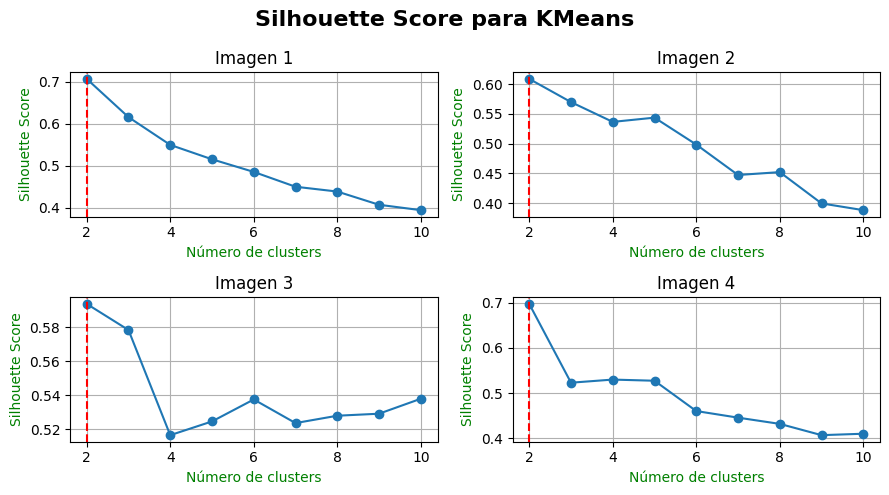

In [ ]:
# Gráfico Silueta
# Contenedor de 4 gráficos (2, 2)
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    ax.plot(k_ranges[i], k_scores[i], marker='o')
    ax.set_title(f"Imagen {i+1}")
    ax.set_xlabel('Número de clusters')
    ax.xaxis.label.set_color('green')
    ax.set_ylabel('Silhouette Score')
    ax.yaxis.label.set_color('green')
    ax.axvline(silhouette_knee[i], color='red', linestyle='--', label=f'Silhouette Point: {silhouette_knee[i]}')
    ax.grid()

fig.suptitle("Silhouette Score para KMeans", fontsize=16, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

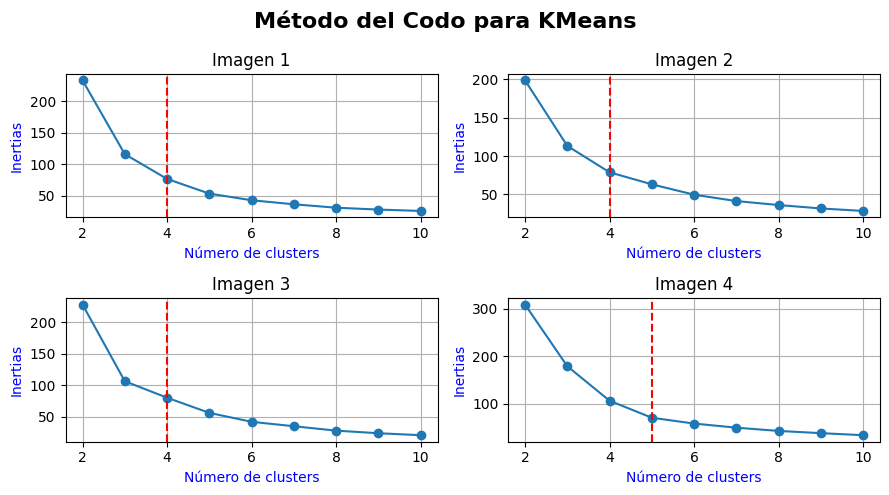

In [ ]:
# Gráfico Codo
# Contenedor de 4 gráficos (2, 2)
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    ax.plot(k_ranges[i], k_inertias[i], marker='o')
    ax.set_title(f"Imagen {i+1}")
    ax.set_xlabel('Número de clusters')
    ax.xaxis.label.set_color('blue')
    ax.set_ylabel('Inertias')
    ax.yaxis.label.set_color('blue')
    ax.axvline(elbow_knee[i], color='red', linestyle='--', label=f'Elbow Point: {elbow_knee[i]}')
    ax.grid()

fig.suptitle("Método del Codo para KMeans", fontsize=16, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

Con el gráfico silueta no es claro el valor maximo.  
Con el gráfico del codo, tal vez el #4 sea el adecuado

#### Ejecución del algoritmo KMedoids para comparar con K-means

In [ ]:
# De las rarezas más extrañas de `from sklearn_extra.cluster import KMedoids`
from pyclustering.cluster.kmedoids import kmedoids
import warnings
warnings.filterwarnings("ignore")

In [ ]:
k_min = 2
k_max = 10
kmedoids_time_execution = []
k_ranges_medo = []
k_scores_medo = []
k_inertias_medo = []
for transformed_image in transformed_images:
    # obtener el coeficiente de la silueta y la inercia
    inicio = time.time()

    k, scores, inertias = silhouette_elbow_function(transformed_image, "kmedoids", k_min, k_max)
    k_ranges_medo.append(k)
    k_scores_medo.append(scores)
    k_inertias_medo.append(inertias)

    fin = time.time()
    kmedoids_time_execution.append(print_seconds(inicio, fin))

# Demora 3min 49.5 segundos

An error occurred: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
An error occurred: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
An error occurred: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
An error occurred: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


In [ ]:
kmedoids_time_execution # Tiempo de ejecución de kmedoids para cada imagen

['Tiempo de ejecución: 70.63 segundos',
 'Tiempo de ejecución: 62.16 segundos',
 'Tiempo de ejecución: 41.78 segundos',
 'Tiempo de ejecución: 57.72 segundos']

😑 Solo procesa 3 imágenes bien. La tercera imagen genera error para obtener el puntaje silueta en el `kmedoids`.   
Nos gustaría eliminar la tercera imagen, pero se deja esto en el taller como evidencia del procesamiento del algoritmo `kmedoids`.

##### Graficar codo y silueta de KMedoids para ver el número de clusters óptimo de cada imagen

In [ ]:
# Usar KneeLocator para encontrar los clusters óptimos
elbow_knee_kmedo = []
silhouette_knee_kmedo = []

In [ ]:
# Encontrar el "codo"
k_inertias_np = np.array(k_inertias_medo)
for i, inertia_np in enumerate(k_inertias_np):
    knee_locator = KneeLocator(cluster_range_np, inertia_np, curve="convex", direction="decreasing")
    optimal_k_elbow = knee_locator.knee
    elbow_knee_kmedo.append(optimal_k_elbow)
    print(f"Elbow K-medoides - Imagen {i+1}: {optimal_k_elbow}")

Elbow K-medoides - Imagen 1: 5
Elbow K-medoides - Imagen 2: 5
Elbow K-medoides - Imagen 3: 2
Elbow K-medoides - Imagen 4: 4


In [ ]:
# Encontrar el mejor número de clusters según Silhouette Score
k_scores_np = np.array(k_scores_medo)
for i, single_score in enumerate(k_scores_np):
    optimal_k_silhouette = cluster_range[np.argmax(single_score)]
    silhouette_knee_kmedo.append(optimal_k_silhouette)
    print(f"Silhouette K-medoides - Imagen {i+1}: {optimal_k_silhouette}")

Silhouette K-medoides - Imagen 1: 2
Silhouette K-medoides - Imagen 2: 2
Silhouette K-medoides - Imagen 3: 6
Silhouette K-medoides - Imagen 4: 2


Como se observa en los resultados para "Elbow" y "Silhouette", no nos podemos fiar de los valores de la tercera imagen (Imagen 3), dado que el modelo no generó bien los `model_k.labels_` para procesar el coeficiente de la silueta.

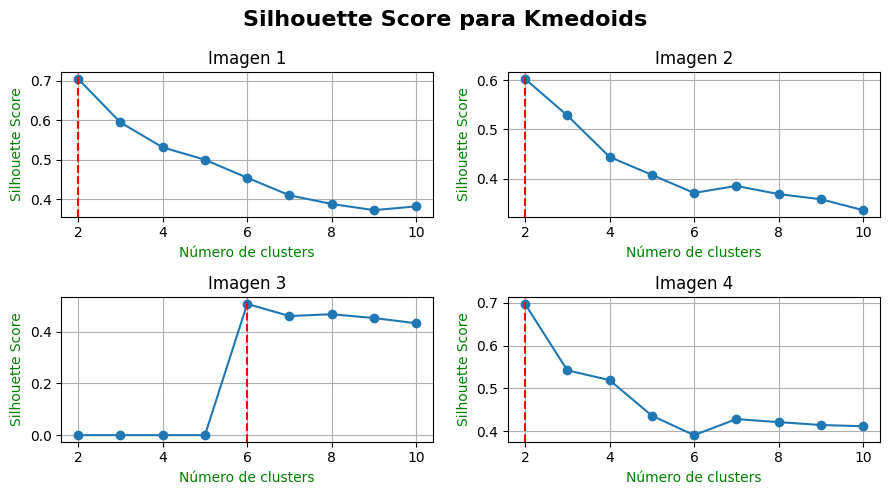

In [ ]:
# Gráfico Silueta
# Contenedor de 4 gráficos (2, 2)
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    ax.plot(k_ranges_medo[i], k_scores_medo[i], marker='o')
    ax.set_title(f"Imagen {i+1}")
    ax.set_xlabel('Número de clusters')
    ax.xaxis.label.set_color('green')
    ax.set_ylabel('Silhouette Score')
    ax.yaxis.label.set_color('green')
    ax.axvline(silhouette_knee_kmedo[i], color='red', linestyle='--', label=f'Silhouette Point: {silhouette_knee_kmedo[i]}')
    ax.grid()

fig.suptitle("Silhouette Score para Kmedoids", fontsize=16, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

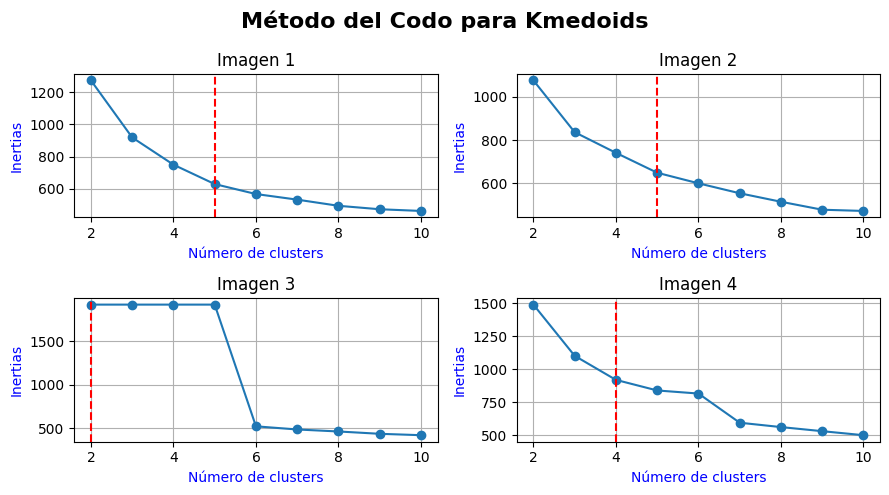

In [ ]:
# Gráfico Codo
# Contenedor de 4 gráficos (2, 2)
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
for i, ax in enumerate(axes.flat):
    ax.plot(k_ranges_medo[i], k_inertias_medo[i], marker='o')
    ax.set_title(f"Imagen {i+1}")
    ax.set_xlabel('Número de clusters')
    ax.xaxis.label.set_color('blue')
    ax.set_ylabel('Inertias')
    ax.yaxis.label.set_color('blue')
    ax.axvline(elbow_knee_kmedo[i], color='red', linestyle='--', label=f'Elbow Point: {elbow_knee_kmedo[i]}')
    ax.grid()

fig.suptitle("Método del Codo para Kmedoids", fontsize=16, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

### Selección hiperparámetro K de K-means y Kmedoids
Comparación resultados de encontrar el mejor número óptimo de clusters usando los algoritmos K-means y Kmedoids.

In [ ]:
optimal_clusters = {
        "Ruta imagen": list_images_routes,
        "Elbow Kmeans": elbow_knee,
        "Silhouette Kmeans": silhouette_knee,
        "Elbow Kmedoids": elbow_knee_kmedo,
        "Silhouette Kmedoids": silhouette_knee_kmedo,
    }
df_resultado = pd.DataFrame(optimal_clusters)
df_resultado

,Ruta imagen,Elbow Kmeans,Silhouette Kmeans,Elbow Kmedoids,Silhouette Kmedoids
0,wikiart_images/adam-baltatu_olt-river-at-cozia...,4,2,5,2
1,wikiart_images/adolphe-joseph-thomas-monticell...,4,2,5,2
2,wikiart_images/allan-ramsay_portrait-of-king-g...,4,2,2,6
3,wikiart_images/edward-hopper_american-village.jpg,5,2,4,2


Jason:: TODO: proveer un análisis de esta tabla, solo por escrito.   
Voy a seguir con las métricas de kmeans para procesar el PCA...

Con el método k-means, conseguimos resultados más especificos para nuestras imágenes; la silueta nos proporciona solo 2 por todas en k-means. Con K-medoids, el codo también tiene una precisión superior a la del método de silueta. No obstante, este modelo malinterpreta la tercera representación en ambos métodos con K-medoids.

**Usaremos las métricas de evaluación de Kmeans del método del codo para obtener la paleta de colores de las imágenes.**

Función para cada imagen

In [ ]:
## Pasos en general detectados para procesar una imagen y obtener los clusters óptimos → implementar esto en los pipelines
ancho_nuevo = 100 #300
alto_nuevo = 100 #200
max_iteraciones = 300

def transformar_imagen(ruta_imagen):
    '''
    Procesar una imagen para obtener la paleta de colores.
    Args:
        image (imagen JPG): imagen original sin transformaciones
    Returns:
        ##centroids (ndarray): Initialized centroids
    '''
    # 0. Leer la imagen de la ruta
    image = cv.imread(ruta_imagen)
    # 1. obtener el color RGB de la imagen original
    image_rgb = get_rgb_color(image)
    # 2. Cambiar el tamaño de la imagen
    image_resized = resize_image(image_rgb, ancho_nuevo, alto_nuevo)
    # 3. Aplanar imagen
    image_reshape = flatten_images(image_resized)
    # 4. Normalizar imagen
    image_normalize = normalize_image(image_reshape)

    return image, image_resized, image_reshape, image_normalize


def ejecutar_algoritmo_agrupacion(model, image_normalize, clusters_codo):
    # Ejecutar Kmeans
    if model == "kmeans":
        model_partition = KMeans(n_clusters=clusters_codo, max_iter=max_iteraciones, n_init=10, random_state=glb_random_state) # para que es ese n_init=10?
    else:
        model_partition = KMedoids(n_clusters=clusters_codo, max_iter=max_iteraciones, random_state=glb_random_state, metric='euclidean') ## ‘pam’ is more accurate.  method='pam' superdemoradd, con 16 clusteres 20 min, con 4 clusteres:

    model_partition.fit(image_normalize)
    score_silueta = 0
    try:
        score_silueta = silhouette_score(image_normalize, model_partition.labels_)
    except Exception as e:
        print(f"An error occurred: {e}")

    inertias = model_partition.inertia_
    centroides = model_partition.cluster_centers_
    labels = model_partition.labels_
    return centroides, inertias, score_silueta, labels

Tomar las versiones de la foto image, image_resized, image_reshape e image_normalize.

In [ ]:
image, image_resized, image_reshape, image_normalize = transformar_imagen(list_images_routes[1])

Asiñamos el numero de clusters y corremos la funcion para obtener todo.

In [ ]:
clusters_codo_kmeans = 4 # segun el metodo del codo de kmeans para las distintas 4 imagenes es 4 o 5, mejor 5.
centroides, inertias, score_silueta, labels = ejecutar_algoritmo_agrupacion("kmeans", image_normalize, clusters_codo_kmeans)

Encontramos el tamaño de la imagen despues de cambiar el tamaño.

In [ ]:
image_resized.shape #img_original

(100, 100, 3)

El tamaño de normalizar la imagen.

In [ ]:
image_normalize.shape

(10000, 3)

Segmentamos la imagen usando centroides.

In [ ]:
img_segmented = centroides[labels]*255
img_segmented = img_segmented.reshape(image_resized.shape)

Mostramos la differencia entre la imagen original y segmentada con KMeans.

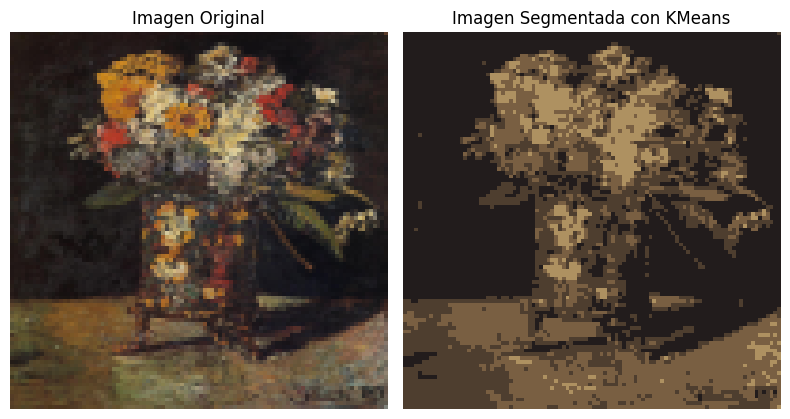

In [ ]:
plt.figure(figsize=(8, 9))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(image_resized)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada con KMeans')
plt.imshow(img_segmented.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

Obtenemos la paleta con esta funcion.

In [ ]:
# Del profe Andrew Ng:
def show_centroid_colors(centroids):
    palette = np.expand_dims(centroids, axis=0)
    num = np.arange(0,len(centroids))
    plt.figure(figsize=(4, 4))
    plt.xticks(num)
    plt.yticks([])
    plt.imshow(palette)

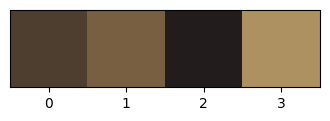

In [ ]:
show_centroid_colors(centroides) # son los colores de la imagen segmentada, tal vez la resolucion 100 x 100 si afecta generando paleta de colores

Ahora lo hagamos con el kmedoids y la funcion.

In [ ]:
clusters_codo_kmed = 5 # segun el metodo del codo de kmedoides para 2 imagenes es 5, mejor 5.
centroides_kmed, inertias_kmed, score_silueta_kmed, labels_kmed = ejecutar_algoritmo_agrupacion("kmedoides", image_normalize, clusters_codo_kmed)
# 20 min 49.7 seg : cuando KMedoids tiene 16 clusters, y tiene estos metodos: metric='euclidean', method='pam'
# 7.1 segundos: cuando KMedoids tiene 5 clusters, y tiene estos metodos: metric='euclidean'

La diferencia entre la imagen original y la segmentada con kMedoids.

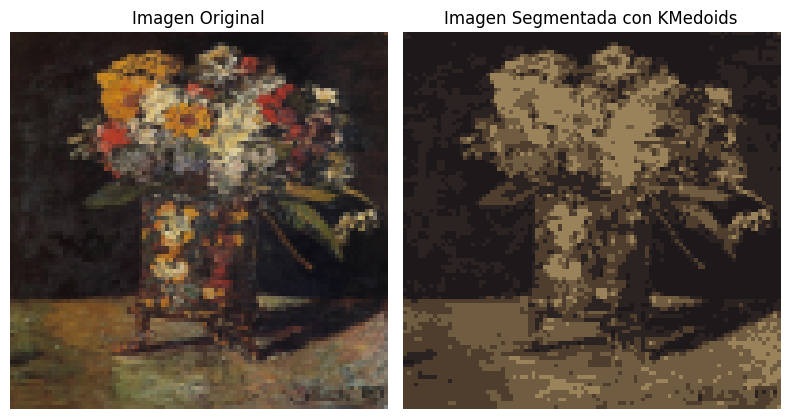

In [ ]:
img_segmented = centroides_kmed[labels_kmed]*255
img_segmented = img_segmented.reshape(image_resized.shape)
plt.figure(figsize=(8, 9))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(image_resized)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada con KMedoids')
plt.imshow(img_segmented.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

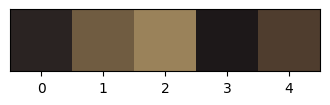

In [ ]:
show_centroid_colors(centroides_kmed)

#### Reducción de la dimensionalidad con PCA
Se usa PCA para reducir la dimensionalidad y ver la varianza explicada.

In [ ]:
pca = PCA(n_components=3) # 2 = 2D  3=3D
# pixels_pca = pca.fit_transform(image_normalize) #Hace FIT y Transform en un solo paso
pca_fit = pca.fit(image_normalize)
pixels_pca = pca_fit.transform(image_normalize)

In [ ]:
pixels_pca # pixeles reducidos a 2D

array([[-0.19470577, -0.02462418, -0.00478051],
       [-0.20464851, -0.02101823,  0.00169452],
       [-0.21770802, -0.02463364,  0.00265501],
       ...,
       [ 0.17495017,  0.05970885, -0.00901175],
       [ 0.15760462,  0.08562694, -0.01920455],
       [ 0.41071372,  0.18352396, -0.01994712]])

t-SNE para reducir la dimensionalidad y ver la varianza explicada.

In [ ]:
# Aplicar t-SNE para reducción no lineal a 2D
tsne = TSNE(n_components=3, random_state=glb_random_state, perplexity=30, verbose=1) #verbose=1 para ver el progreso
pixels_tsne = tsne.fit_transform(image_normalize)
# 54.9 segundos con 2 componentes
# 3min 13.7 seg con 3 componentes

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.004120
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.612762
[t-SNE] KL divergence after 1000 iterations: 0.800822


Ahora vemos la distribucion y el t-SNE de los colores.

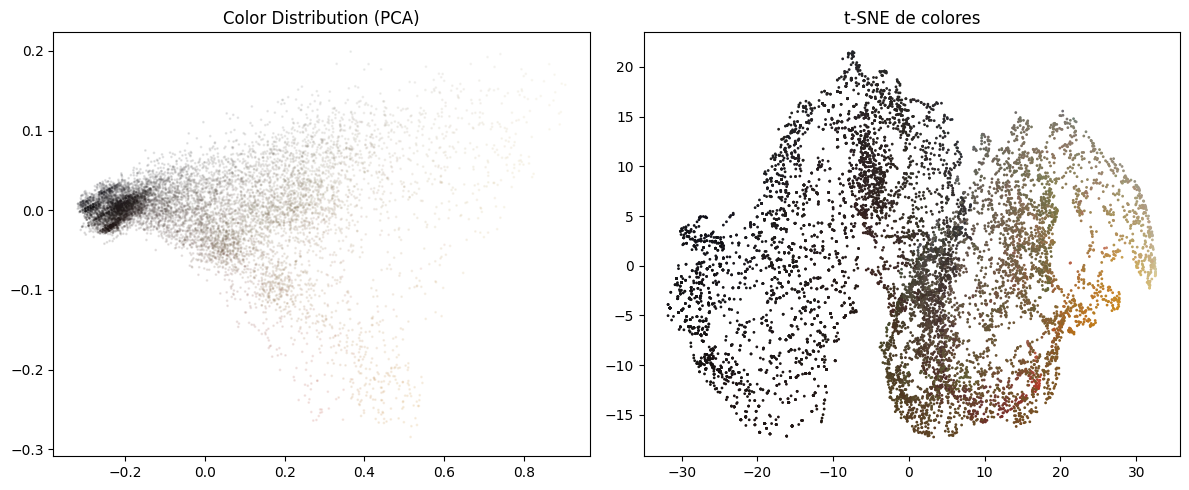

In [ ]:
division_c = image_reshape / 255

# Visualizar la distribución de colores con PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pixels_pca[:, 0], pixels_pca[:, 1], c=division_c, s=1, alpha=0.1)
plt.title('Color Distribution (PCA)')

# Visualización de t-SNE
plt.subplot(1, 2, 2)
plt.scatter(pixels_tsne[:, 0], pixels_tsne[:, 1], c=division_c, s=1)
plt.title("t-SNE de colores")

plt.tight_layout()
plt.show()

La varianza explicada.

In [ ]:
sum(pca_fit.explained_variance_ratio_)  # pca.explained_variance_ration_ returns a list where it shows the amount of variance explained by each principal component.

1.0

La suma cumalativa de la varrianza

In [ ]:
cumsum = np.cumsum(pca_fit.explained_variance_ratio_)
cumsum

array([0.94330027, 0.99284335, 1.        ])

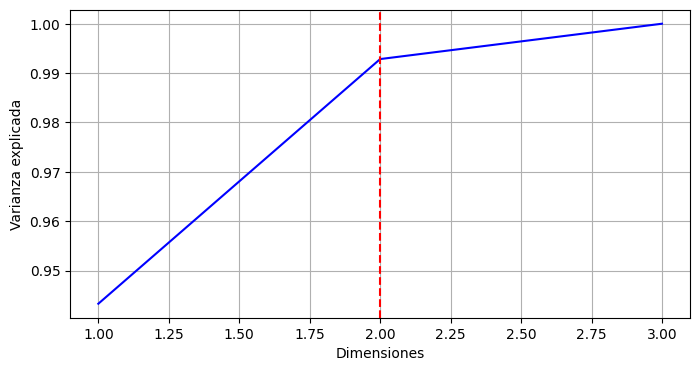

In [ ]:
# Ahora encontrar cantidad de componentes que expliquen el 95% de la varianza
exp_var = 0.95

plt.figure(figsize=(8, 4))
x = np.arange(1,len(cumsum)+1)
d = np.argmax(cumsum >= exp_var) + 1
plt.plot(x, cumsum, linestyle='-', color='b')
plt.axvline(x=d, color='red', linestyle='--')
plt.xlabel('Dimensiones')
plt.ylabel('Varianza explicada')
plt.grid(True)
plt.show()

In [ ]:
# Si n_components es un valor entre 0 y 1, se considera como la cantidad de varianza explicada
pca = PCA(n_components=exp_var)
x_reduced = pca.fit_transform(image_normalize)

In [ ]:
# Ahora encontrar cantidad de componentes que expliquen el 95% de la varianza
pca.n_components_

2

Con **2** componentes explica el **95%** de la varianza.

## Implementación con Pipeline

In [ ]:
image_rgb = get_rgb_color(list_images_resized[0])
model = "kmeans"

In [ ]:
steps = [
    ("resize", ),
    ("flatten", FunctionTransformer(flatten_images)),
    ("normalize", FunctionTransformer(normalize_image)),
    ("model", ejecutar_algoritmo_agrupacion(model, image_normalize,clusters_codo_kmeans)),
    ("show_centroid_colors", FunctionTransformer(show_centroid_colors, kw_args={'centroids': centroides}))
]

In [ ]:
pipeline = Pipeline(steps)

In [ ]:
pixels_pca = pipeline.fit_transform(image_rgb)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '(array([[0.30969258, 0.24345   , 0.1871104 ],
       [0.47576721, 0.37568732, 0.2602355 ],
       [0.1348554 , 0.11233706, 0.11269677],
       [0.68303245, 0.56916875, 0.38189514]]), 78.76662089725441, 0.536691557844892, array([2, 2, 2, ..., 1, 1, 3], dtype=int32))' (type <class 'tuple'>) doesn't

## n. otros

## Conclusiones